In [6]:
# Notebook Cell

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
import tifffile

from pystar.infrastructure import load_config
from pystar.io import ImageLoader
from pystar.preprocessing import DataSanitizer
from pystar.visualization import compare_preprocessing_5regions

# 1. 初始化
config_path = "experiment_config.yaml"
cfg = load_config(config_path)

# 打印当前预处理流水线步骤
# 使用对象属性访问 (.method)
print(f"Process List: {[step.method for step in cfg.pipeline.preprocessing.sequence]}")


# 初始化核心组件
loader = ImageLoader(cfg)

# 参数设定
FOV_ID = 1
ROUND_ID = 1  # 我们的测试目标
Z_PLANE = 20  # 选择 Z-stack 中间的某一层（假设总共40层）



Process List: ['none', 'min_max_normalize', 'histogram_match', 'histogram_match', 'morpho_reconstruction_contrast']



--- Starting Preprocessing Test on FOV 1 ---
[==================== Sanitizing FOV 1 ====================]
 -> DEBUG: Only processing user-selected rounds: [1]
 -> Pipeline Split: 4 Calibration steps + 1 Extraction steps
 -> Processing Round 1...
--- Fineshed in 281.92 seconds ---

--- Loading data for Inspection (Channels: [0, 1, 2]) ---
Data Shape: (3, 42, 2048, 2048)
Generating 5-Region Report at Z=21 ...


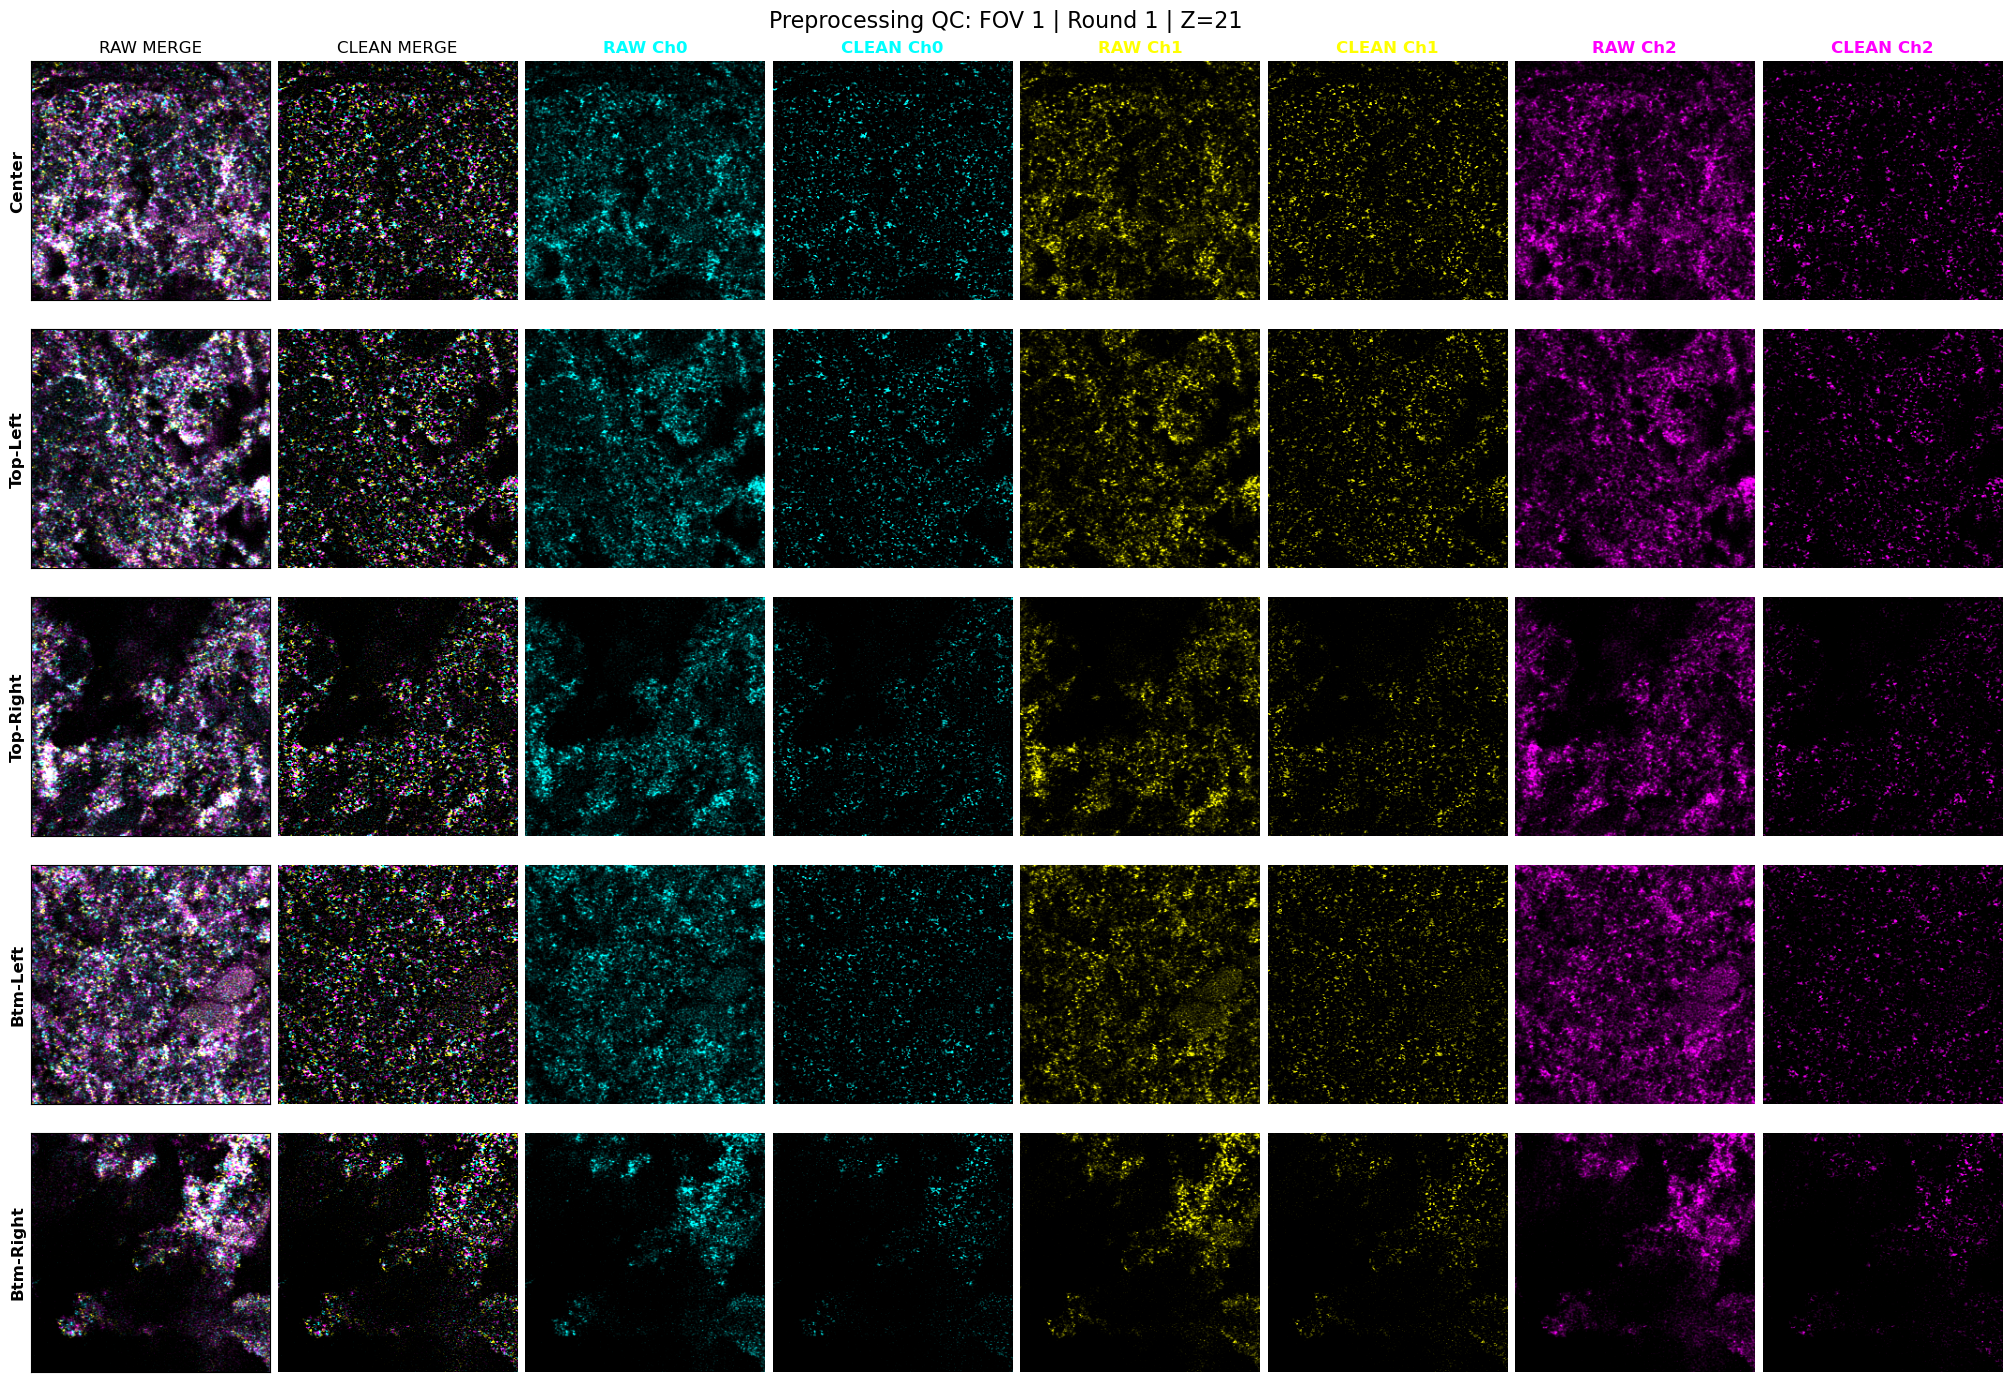

In [7]:


# ==========================================
# 2. 运行单 FOV 测试 (The Trial Run)
# ==========================================
# 选一个具有代表性的 FOV，比如中间的
target_fov = 1
# 选要测试的 Round（通常是 R1，因为它是 Reference）
target_round = 1

print(f"\n--- Starting Preprocessing Test on FOV {target_fov} ---")
start_time = time.time()

sanitizer = DataSanitizer(cfg)

# 这一步会真正调用你的 Two-Phase 逻辑，并把结果写到 clean_data 目录
# 我们测试完整的写盘流程，而不是在内存里玩耍，这样确保存储逻辑也没bug
sanitizer.sanitize_fov(target_fov, target_rounds=[target_round]) 

print(f"--- Fineshed in {time.time() - start_time:.2f} seconds ---")

# ==========================================
# 3. 数据回填 (Feedback Loop)
# ==========================================
# 现在我们把 RAW 和 CLEAN 都读进内存，组装成 (C, Z, Y, X)
# 以便喂给可视化函数

roles = cfg.dataset.channel_roles
seq_channels = sorted([c for c, role in roles.items() if role == 'seq'])

raw_stack = []
clean_stack = []

print(f"\n--- Loading data for Inspection (Channels: {seq_channels}) ---")

for c in seq_channels:
    # A. Load Raw
    # 使用 lazy_load 并立即 compute，拿到 numpy array
    p_raw = loader._get_path(target_fov, target_round, c)
    vol_raw = loader._lazy_load_tiff(p_raw).compute()
    
    # B. Load Clean (刚刚生成的)
    vol_clean = loader.load_clean_image(target_fov, target_round, c)
    
    raw_stack.append(vol_raw)
    clean_stack.append(vol_clean)

# Stack -> (C, Z, Y, X)
raw_4d = np.stack(raw_stack, axis=0)
clean_4d = np.stack(clean_stack, axis=0)

print(f"Data Shape: {raw_4d.shape}")

# ==========================================
# 4. 显微镜检查 (The Verify)
# ==========================================
# 选一个中间的 Z 层
z_mid = raw_4d.shape[1] // 2

# 定义输出路径 (可选，如果不传路径会直接显示)
#qc_output = Path("notebook_outputs")
#qc_output.mkdir(exist_ok=True)
#save_path = qc_output / f"QC_Preprocess_FOV{target_fov}_R{target_round}.png"

print(f"Generating 5-Region Report at Z={z_mid} ...")

compare_preprocessing_5regions(
    raw_vol=raw_4d,
    clean_vol=clean_4d,
    z_plane=z_mid,
    fov_id=target_fov,
    round_id=target_round,
    roi_size=256, # 看大一点的窗口
    output_path=None # 设为 None 以便在 Notebook 直接显示，设为 save_path 保存
)


--- Loading data for Inspection (Channels: [0, 1, 2]) ---
Data Shape: (3, 42, 2048, 2048)
Generating 5-Region Report at Z=21 ...


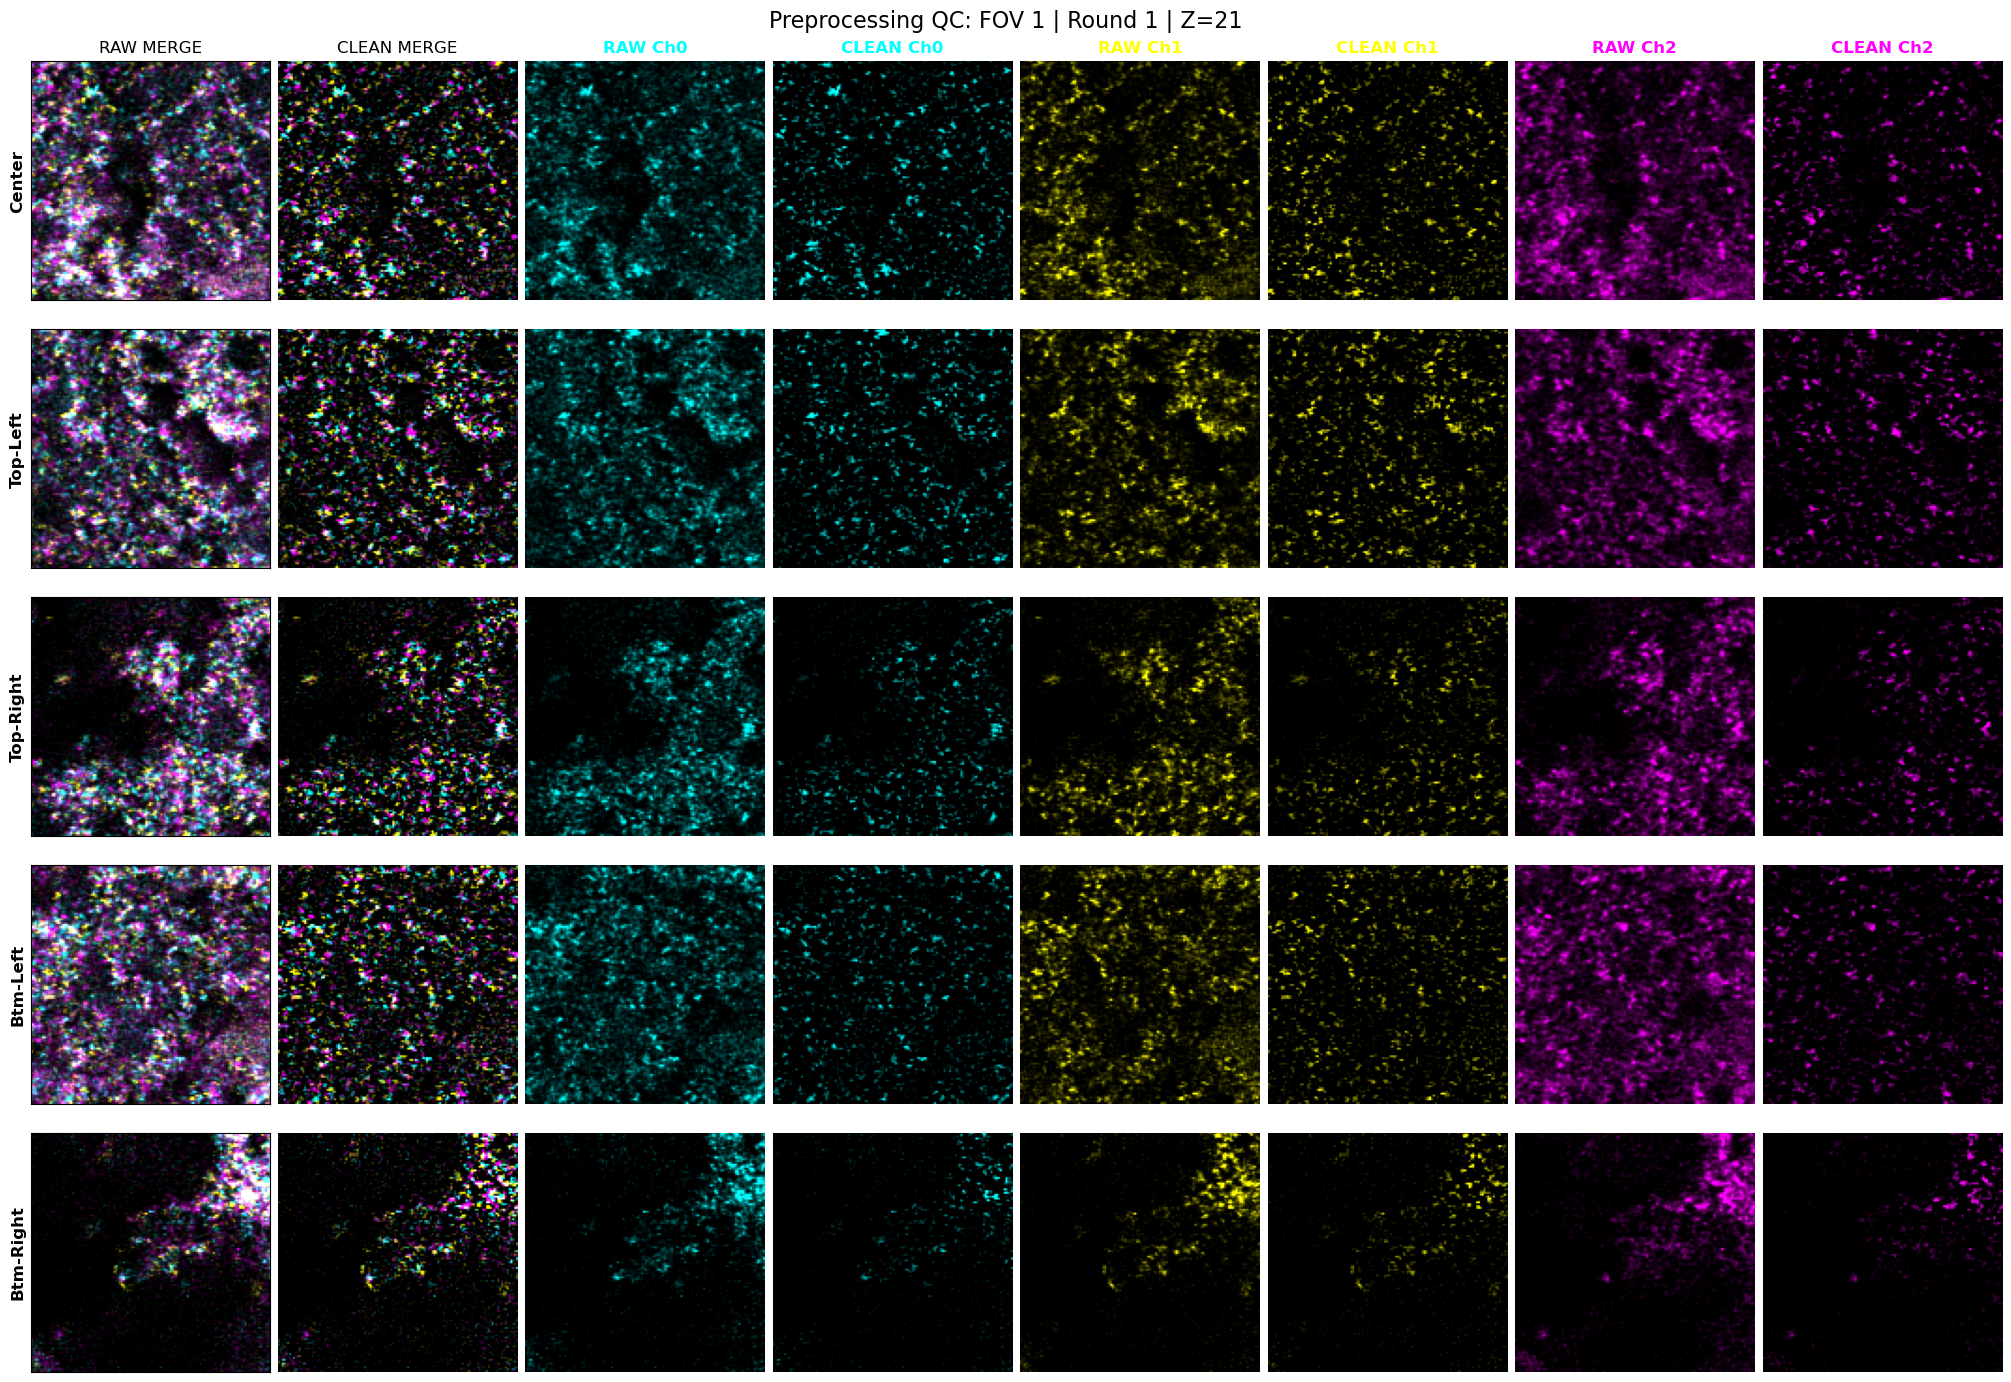

In [4]:

target_fov = 1
# 选要测试的 Round（通常是 R1，因为它是 Reference）
target_round = 1


# ==========================================
# 3. 数据回填 (Feedback Loop)
# ==========================================
# 现在我们把 RAW 和 CLEAN 都读进内存，组装成 (C, Z, Y, X)
# 以便喂给可视化函数

roles = cfg.dataset.channel_roles
seq_channels = sorted([c for c, role in roles.items() if role == 'seq'])

raw_stack = []
clean_stack = []

print(f"\n--- Loading data for Inspection (Channels: {seq_channels}) ---")

for c in seq_channels:
    # A. Load Raw
    # 使用 lazy_load 并立即 compute，拿到 numpy array
    p_raw = loader._get_path(target_fov, target_round, c)
    vol_raw = loader._lazy_load_tiff(p_raw).compute()
    
    # B. Load Clean (刚刚生成的)
    vol_clean = loader.load_clean_image(target_fov, target_round, c)
    
    raw_stack.append(vol_raw)
    clean_stack.append(vol_clean)

# Stack -> (C, Z, Y, X)
raw_4d = np.stack(raw_stack, axis=0)
clean_4d = np.stack(clean_stack, axis=0)

print(f"Data Shape: {raw_4d.shape}")

# ==========================================
# 4. 显微镜检查 (The Verify)
# ==========================================
# 选一个中间的 Z 层
z_mid = raw_4d.shape[1] // 2

# 定义输出路径 (可选，如果不传路径会直接显示)
#qc_output = Path("notebook_outputs")
#qc_output.mkdir(exist_ok=True)
#save_path = qc_output / f"QC_Preprocess_FOV{target_fov}_R{target_round}.png"

print(f"Generating 5-Region Report at Z={z_mid} ...")

compare_preprocessing_5regions(
    raw_vol=raw_4d,
    clean_vol=clean_4d,
    z_plane=z_mid,
    fov_id=target_fov,
    round_id=target_round,
    roi_size=128, # 看大一点的窗口
    output_path=None # 设为 None 以便在 Notebook 直接显示，设为 save_path 保存
)


--- Loading data for Inspection (Channels: [0, 1, 2]) ---
Data Shape: (3, 42, 2048, 2048)
Generating 5-Region Report at Z=21 ...


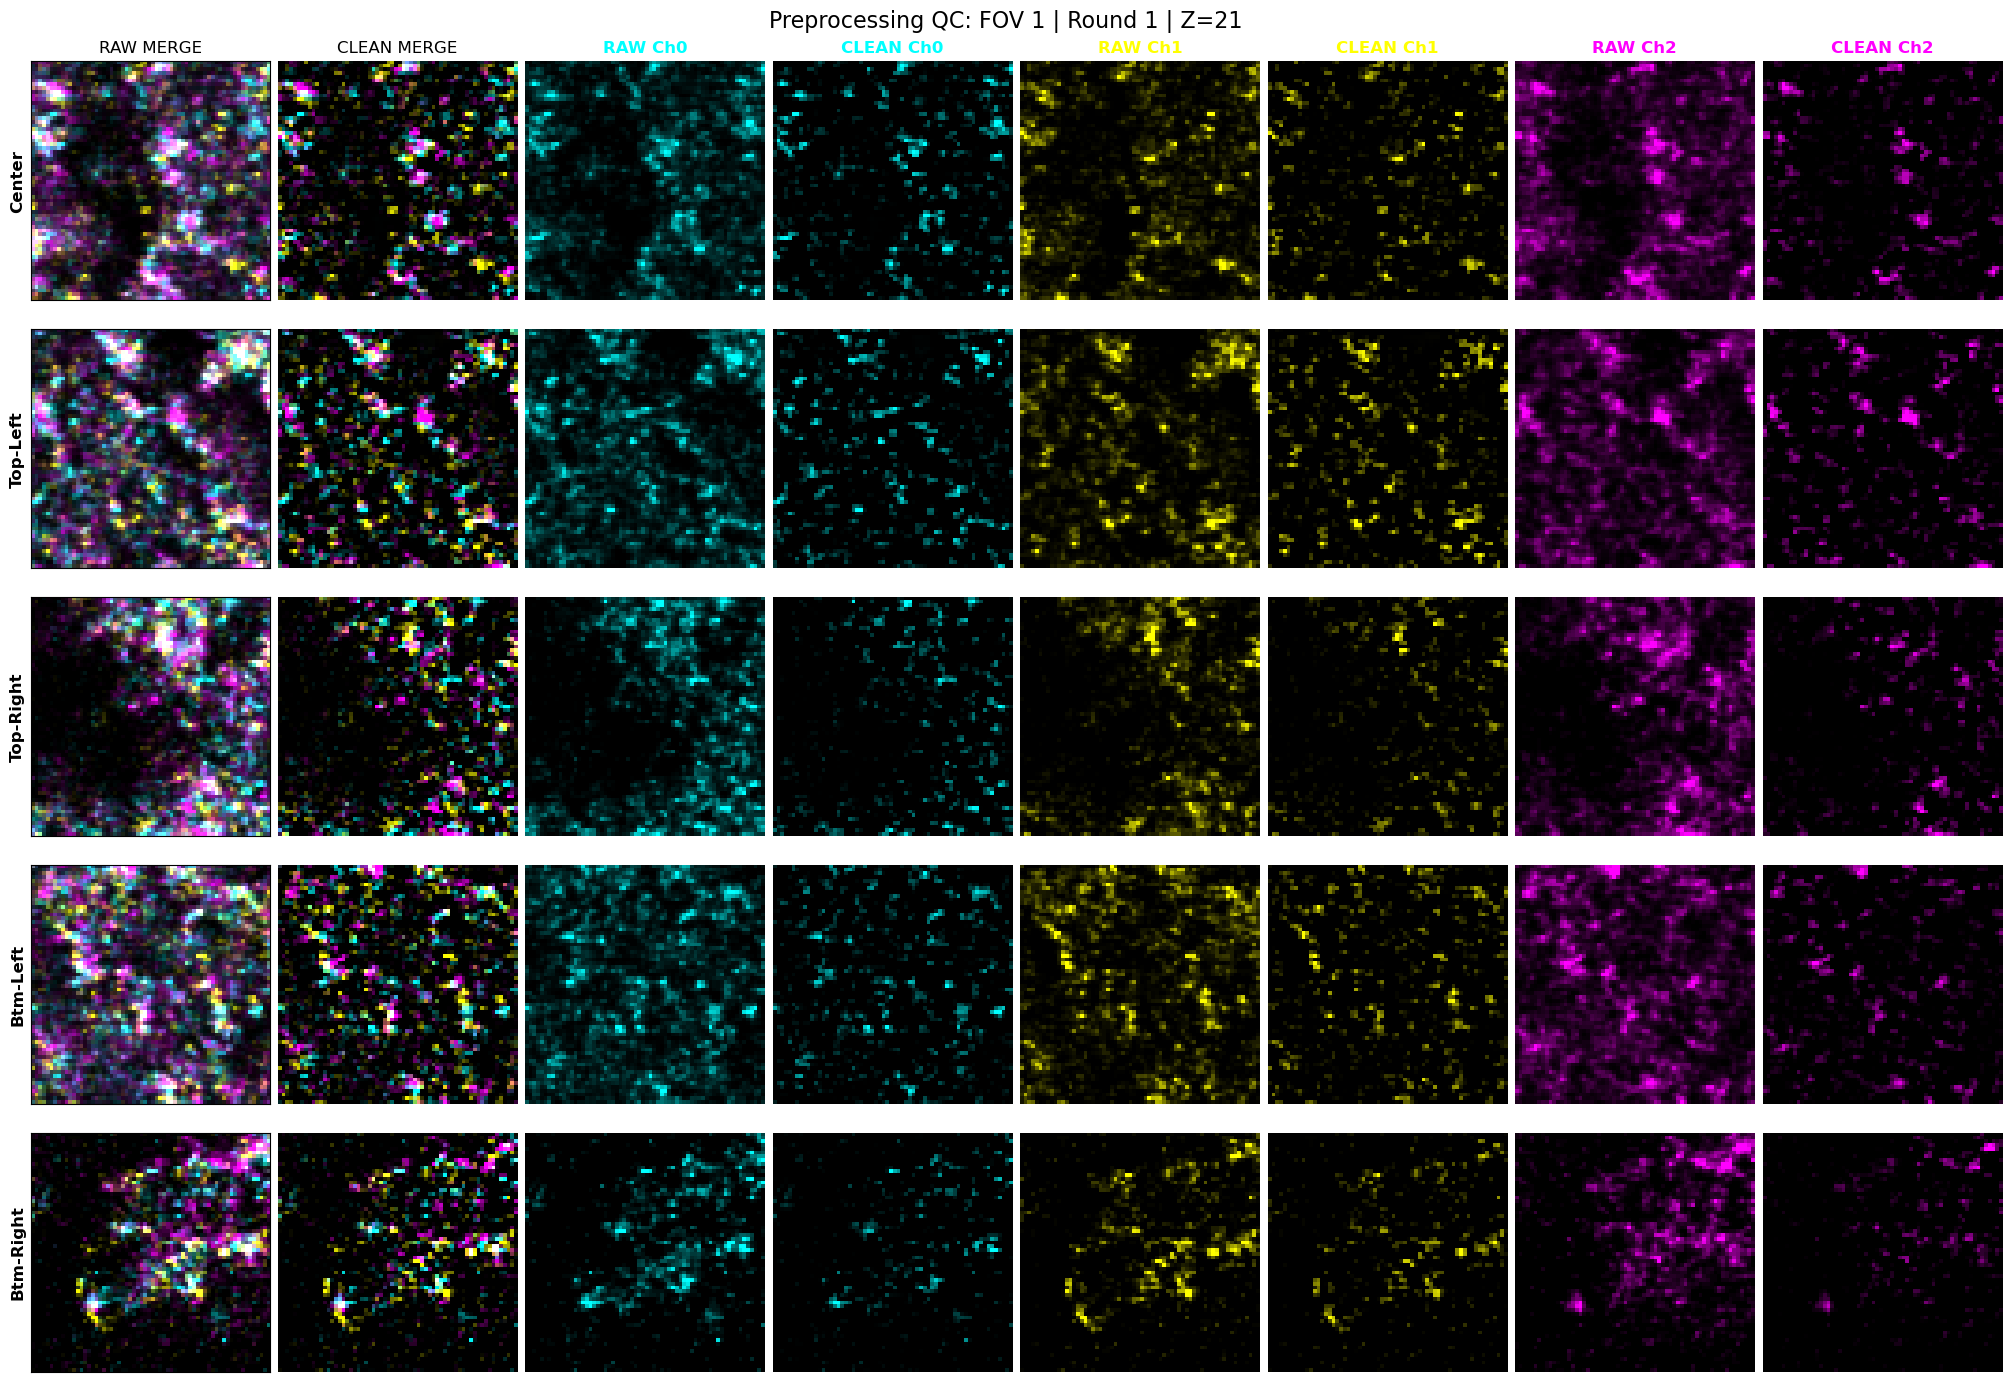

In [3]:

target_fov = 1
# 选要测试的 Round（通常是 R1，因为它是 Reference）
target_round = 1


# ==========================================
# 3. 数据回填 (Feedback Loop)
# ==========================================
# 现在我们把 RAW 和 CLEAN 都读进内存，组装成 (C, Z, Y, X)
# 以便喂给可视化函数

roles = cfg.dataset.channel_roles
seq_channels = sorted([c for c, role in roles.items() if role == 'seq'])

raw_stack = []
clean_stack = []

print(f"\n--- Loading data for Inspection (Channels: {seq_channels}) ---")

for c in seq_channels:
    # A. Load Raw
    # 使用 lazy_load 并立即 compute，拿到 numpy array
    p_raw = loader._get_path(target_fov, target_round, c)
    vol_raw = loader._lazy_load_tiff(p_raw).compute()
    
    # B. Load Clean (刚刚生成的)
    vol_clean = loader.load_clean_image(target_fov, target_round, c)
    
    raw_stack.append(vol_raw)
    clean_stack.append(vol_clean)

# Stack -> (C, Z, Y, X)
raw_4d = np.stack(raw_stack, axis=0)
clean_4d = np.stack(clean_stack, axis=0)

print(f"Data Shape: {raw_4d.shape}")

# ==========================================
# 4. 显微镜检查 (The Verify)
# ==========================================
# 选一个中间的 Z 层
z_mid = raw_4d.shape[1] // 2

# 定义输出路径 (可选，如果不传路径会直接显示)
#qc_output = Path("notebook_outputs")
#qc_output.mkdir(exist_ok=True)
#save_path = qc_output / f"QC_Preprocess_FOV{target_fov}_R{target_round}.png"

print(f"Generating 5-Region Report at Z={z_mid} ...")

compare_preprocessing_5regions(
    raw_vol=raw_4d,
    clean_vol=clean_4d,
    z_plane=z_mid,
    fov_id=target_fov,
    round_id=target_round,
    roi_size=64, # 看大一点的窗口
    output_path=None # 设为 None 以便在 Notebook 直接显示，设为 save_path 保存
)


--- Loading data for Inspection (Channels: [0, 1, 2]) ---
Data Shape: (3, 42, 2048, 2048)
Generating 5-Region Report at Z=21 ...


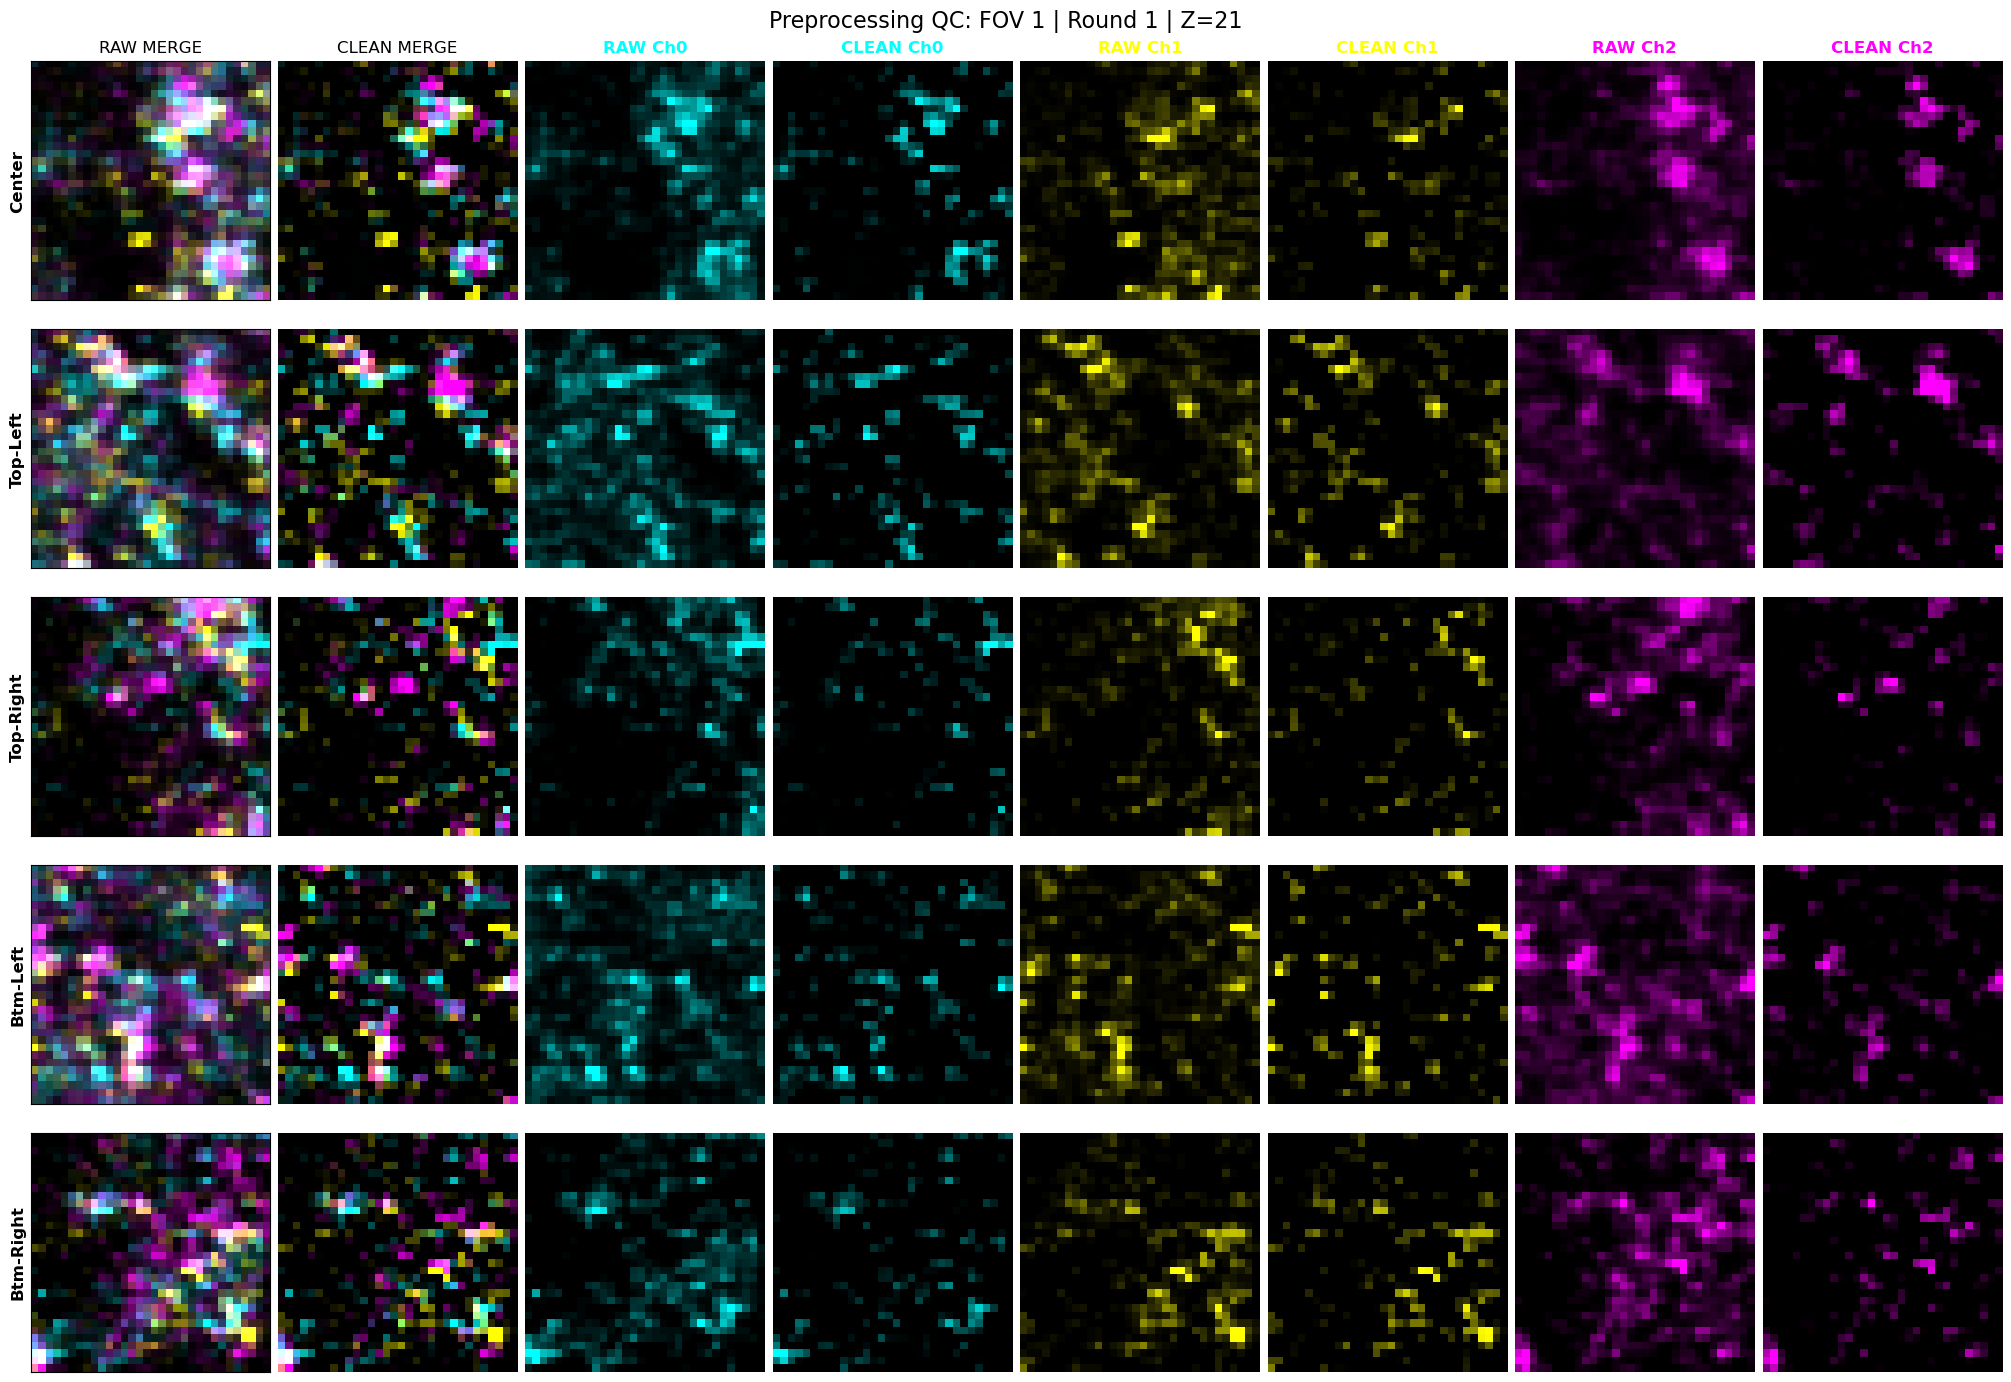

In [5]:

target_fov = 1
# 选要测试的 Round（通常是 R1，因为它是 Reference）
target_round = 1


# ==========================================
# 3. 数据回填 (Feedback Loop)
# ==========================================
# 现在我们把 RAW 和 CLEAN 都读进内存，组装成 (C, Z, Y, X)
# 以便喂给可视化函数

roles = cfg.dataset.channel_roles
seq_channels = sorted([c for c, role in roles.items() if role == 'seq'])

raw_stack = []
clean_stack = []

print(f"\n--- Loading data for Inspection (Channels: {seq_channels}) ---")

for c in seq_channels:
    # A. Load Raw
    # 使用 lazy_load 并立即 compute，拿到 numpy array
    p_raw = loader._get_path(target_fov, target_round, c)
    vol_raw = loader._lazy_load_tiff(p_raw).compute()
    
    # B. Load Clean (刚刚生成的)
    vol_clean = loader.load_clean_image(target_fov, target_round, c)
    
    raw_stack.append(vol_raw)
    clean_stack.append(vol_clean)

# Stack -> (C, Z, Y, X)
raw_4d = np.stack(raw_stack, axis=0)
clean_4d = np.stack(clean_stack, axis=0)

print(f"Data Shape: {raw_4d.shape}")

# ==========================================
# 4. 显微镜检查 (The Verify)
# ==========================================
# 选一个中间的 Z 层
z_mid = raw_4d.shape[1] // 2

# 定义输出路径 (可选，如果不传路径会直接显示)
#qc_output = Path("notebook_outputs")
#qc_output.mkdir(exist_ok=True)
#save_path = qc_output / f"QC_Preprocess_FOV{target_fov}_R{target_round}.png"

print(f"Generating 5-Region Report at Z={z_mid} ...")

compare_preprocessing_5regions(
    raw_vol=raw_4d,
    clean_vol=clean_4d,
    z_plane=z_mid,
    fov_id=target_fov,
    round_id=target_round,
    roi_size=32, # 看大一点的窗口
    output_path=None # 设为 None 以便在 Notebook 直接显示，设为 save_path 保存
)

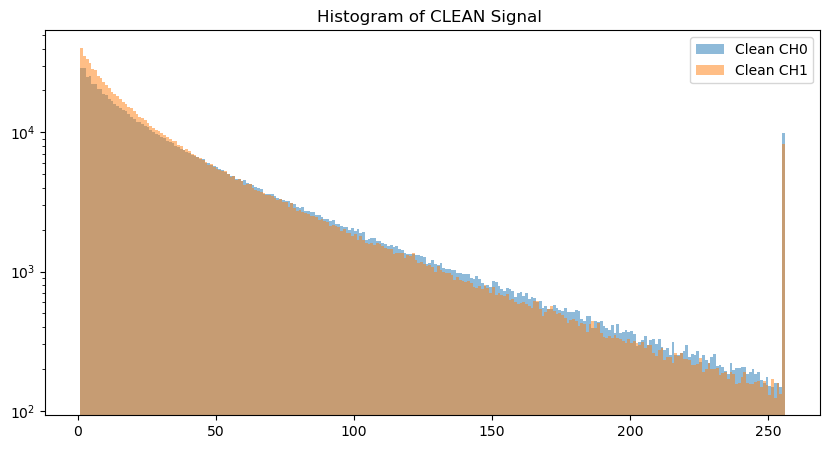

In [8]:
raw_c0 = tifffile.imread(loader._get_path(1, 1, 0))[15]
clean_c0 = tifffile.imread(loader.get_clean_path(1, 1, 0))[15]

raw_c1 = tifffile.imread(loader._get_path(1, 1, 2))[15]
clean_c1 = tifffile.imread(loader.get_clean_path(1, 1, 2))[15]

plt.figure(figsize=(10, 5))
plt.hist(clean_c0.flatten(), bins=255, range=(1, 256), alpha=0.5, label='Clean CH0', log=True)
plt.hist(clean_c1.flatten(), bins=255, range=(1, 256), alpha=0.5, label='Clean CH1', log=True)
plt.legend()
plt.title("Histogram of CLEAN Signal ")
plt.show()